In [1]:
# https://github.com/microsoft/ProDA/blob/main/data/gta5_dataset.py

In [2]:
import os
import torch
import numpy as np
import logging

from PIL import Image

In [7]:
"""Base segmentation dataset"""
import os
import random
import numpy as np
import torchvision

from PIL import Image, ImageOps, ImageFilter
from core.config import cfg


class SegmentationDataset(object):
    """Segmentation Base Dataset"""

    def __init__(self, root, split, mode, transform, base_size=520, crop_size=480):
        super(SegmentationDataset, self).__init__()
        self.root = os.path.join(cfg.ROOT_PATH, root)
        self.transform = transform
        self.split = split
        self.mode = mode if mode is not None else split
        self.base_size = base_size
        self.crop_size = self.to_tuple(crop_size)
        self.color_jitter = self._get_color_jitter()

    def to_tuple(self, size):
        if isinstance(size, (list, tuple)):
            return tuple(size)
        elif isinstance(size, (int, float)):
            return tuple((size, size))
        else:
            raise ValueError('Unsupport datatype: {}'.format(type(size)))

    def _get_color_jitter(self):
        color_jitter = cfg.AUG.COLOR_JITTER
        if color_jitter is None:
            return None
        if isinstance(color_jitter, (list, tuple)):
            # color jitter should be a 3-tuple/list if spec brightness/contrast/saturation
            # or 4 if also augmenting hue
            assert len(color_jitter) in (3, 4)
        else:
            # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
            color_jitter = (float(color_jitter),) * 3
        return torchvision.transforms.ColorJitter(*color_jitter)

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = min(outsize)
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize[1]) / 2.))
        y1 = int(round((h - outsize[0]) / 2.))
        img = img.crop((x1, y1, x1 + outsize[1], y1 + outsize[0]))
        mask = mask.crop((x1, y1, x1 + outsize[1], y1 + outsize[0]))

        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if cfg.AUG.MIRROR and random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < min(crop_size):
            padh = crop_size[0] - oh if oh < crop_size[0] else 0
            padw = crop_size[1] - ow if ow < crop_size[1] else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=-1)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size[1])
        y1 = random.randint(0, h - crop_size[0])
        img = img.crop((x1, y1, x1 + crop_size[1], y1 + crop_size[0]))
        mask = mask.crop((x1, y1, x1 + crop_size[1], y1 + crop_size[0]))
        # gaussian blur as in PSP
        if cfg.AUG.BLUR_PROB > 0 and random.random() < cfg.AUG.BLUR_PROB:
            radius = cfg.AUG.BLUR_RADIUS if cfg.AUG.BLUR_RADIUS > 0 else random.random()
            img = img.filter(ImageFilter.GaussianBlur(radius=radius))
        # color jitter
        if self.color_jitter:
            img = self.color_jitter(img)
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        return np.array(mask).astype('int32')

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0


In [6]:
class CitySegmentation(SegmentationDataset):
    """Cityscapes Semantic Segmentation Dataset.

    Parameters
    ----------
    root : string
        Path to Cityscapes folder. Default is './datasets/cityscapes'
    split: string
        'train', 'val' or 'test'
    transform : callable, optional
        A function that transforms the image
    Examples
    --------
    >>> from torchvision import transforms
    >>> import torch.utils.data as data
    >>> # Transforms for Normalization
    >>> input_transform = transforms.Compose([
    >>>     transforms.ToTensor(),
    >>>     transforms.Normalize((.485, .456, .406), (.229, .224, .225)),
    >>> ])
    >>> # Create Dataset
    >>> trainset = CitySegmentation(split='train', transform=input_transform)
    >>> # Create Training Loader
    >>> train_data = data.DataLoader(
    >>>     trainset, 4, shuffle=True,
    >>>     num_workers=4)
    """
    BASE_DIR = 'citys'
    NUM_CLASS = 19

    def __init__(self, root='G:/data', split='train', mode=None, transform=None, **kwargs):
        super(CitySegmentation, self).__init__(root, split, mode, transform, **kwargs)
        self.root = os.path.join(root, self.BASE_DIR)
        assert os.path.exists(self.root), "Please put dataset in {SEG_ROOT}/datasets/cityscapes"
        self.images, self.mask_paths = _get_city_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')

    def _class_to_index(self, mask):
        # assert the value
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])

    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 0

    @property
    def classes(self):
        """Category names."""
        return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
                'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
                'truck', 'bus', 'train', 'motorcycle', 'bicycle')


def _get_city_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.startswith('._'):
                    continue
                if filename.endswith('.png'):
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskname = filename.replace('leftImg8bit', 'gtFine_labelIds')
                    maskpath = os.path.join(mask_folder, foldername, maskname)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        logging.info('cannot find the mask or image:', imgpath, maskpath)
        logging.info('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    if split in ('train', 'val'):
        img_folder = os.path.join(folder, 'leftImg8bit/' + split)
        mask_folder = os.path.join(folder, 'gtFine/' + split)
        img_paths, mask_paths = get_path_pairs(img_folder, mask_folder)
        return img_paths, mask_paths
    else:
        assert split == 'trainval'
        logging.info('trainval set')
        train_img_folder = os.path.join(folder, 'leftImg8bit/train')
        train_mask_folder = os.path.join(folder, 'gtFine/train')
        val_img_folder = os.path.join(folder, 'leftImg8bit/val')
        val_mask_folder = os.path.join(folder, 'gtFine/val')
        train_img_paths, train_mask_paths = get_path_pairs(train_img_folder, train_mask_folder)
        val_img_paths, val_mask_paths = get_path_pairs(val_img_folder, val_mask_folder)
        img_paths = train_img_paths + val_img_paths
        mask_paths = train_mask_paths + val_mask_paths
    return img_paths, mask_paths

In [4]:
from torchvision import transforms
import torch.utils.data as data

In [37]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [38]:
trainset = CitySegmentation(split='train', transform=train_transforms)
train_data = data.DataLoader(trainset, 16, shuffle=True, num_workers=0)

In [39]:
print(train_data)

In [89]:
sample_image = sample_label = sample_base = None
for (image, label, base) in train_data:
    sample_image = image
    sample_label = label
    sample_base = base
    break

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

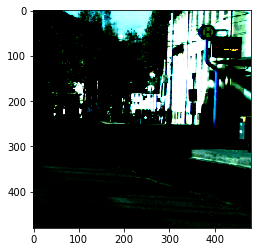

In [79]:
plt.imshow(np.transpose(sample_image[0,0:3], (1, 2, 0)))

In [91]:
sample_label.shape

torch.Size([16, 480, 480])

In [99]:
sample_label[1:3].shape

torch.Size([2, 480, 480])

In [123]:
gta_image = Image.open("G:/data/gta/images/00016.png").convert('RGB')
gta_label = Image.open("G:/data/gta/labels/00016.png").convert('RGB')

In [149]:
NUM_CLASS = 19

colors = [  # [  0,   0,   0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [0, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
]

void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, 34, -1]
valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,]
ignore_index = 250
class_map = dict(zip(valid_classes, range(19)))

In [153]:
def encode_segmap(lbl):
        for _i in void_classes:
            lbl[lbl == _i] = ignore_index
        for _i in valid_classes:
            lbl[lbl == _i] = class_map[_i]
        return dict(zip(range(NUM_CLASS), colors))

def decode_segmap(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, NUM_CLASS):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [157]:
encode_segmap(np.array(gta_label))

{0: [128, 64, 128],
 1: [244, 35, 232],
 2: [70, 70, 70],
 3: [102, 102, 156],
 4: [190, 153, 153],
 5: [153, 153, 153],
 6: [250, 170, 30],
 7: [220, 220, 0],
 8: [107, 142, 35],
 9: [152, 251, 152],
 10: [0, 130, 180],
 11: [220, 20, 60],
 12: [255, 0, 0],
 13: [0, 0, 142],
 14: [0, 0, 70],
 15: [0, 60, 100],
 16: [0, 80, 100],
 17: [0, 0, 230],
 18: [119, 11, 32]}

In [144]:
n[1].shape

(1914, 3)

In [129]:
t = decode_segmap(np.array(gta_label))

ValueError: could not broadcast input array from shape (1052,1914,3) into shape (1052,1914)